# Simple CNN Implemented using Keras. for MNIST DATASET

## IMPORTING DEPENDENCIES

In [55]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

In [56]:
# Load a sample dataset (MNIST for simplicity)
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [57]:
# Normalize and reshape data
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_train = np.expand_dims(x_train, axis=-1) # Add channel dimension
x_test = np.expand_dims(x_test, axis=-1)

In [58]:
# Define a simple CNN model
model = keras.Sequential([
layers.Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1)),
layers.MaxPooling2D((2, 2)),
layers.Conv2D(64, (3, 3), activation="relu"),
layers.MaxPooling2D((2, 2)),
layers.Flatten(),
layers.Dense(128, activation="relu"),
layers.Dense(10, activation="softmax") # 10 classes for MNIST digits
])

In [59]:
# Compile the model
model.compile(optimizer="adam",

loss="sparse_categorical_crossentropy",
metrics=["accuracy"])

In [60]:
# Train the model
model.fit(x_train, y_train, epochs=5, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9051 - loss: 0.2982 - val_accuracy: 0.9867 - val_loss: 0.0421
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9865 - loss: 0.0429 - val_accuracy: 0.9888 - val_loss: 0.0336
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9909 - loss: 0.0277 - val_accuracy: 0.9898 - val_loss: 0.0315
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9929 - loss: 0.0217 - val_accuracy: 0.9897 - val_loss: 0.0324
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9953 - loss: 0.0144 - val_accuracy: 0.9910 - val_loss: 0.0307


In [61]:
# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9872 - loss: 0.0414
Test accuracy: 0.9910


In [62]:
# Make predictions
predictions = model.predict(x_test[:5])
predicted_labels = np.argmax(predictions, axis=1)
print("Predicted labels:", predicted_labels)
print("Actual labels: ", y_test[:5])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
Predicted labels: [7 2 1 0 4]
Actual labels:  [7 2 1 0 4]


# End-to-End CNN Model for Image Classification

In [63]:
!unzip /content/FruitinAmazon.zip -d /content

unzip:  cannot find or open /content/FruitinAmazon.zip, /content/FruitinAmazon.zip.zip or /content/FruitinAmazon.zip.ZIP.


# Importing Dependencies

In [64]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import numpy as np
from sklearn.metrics import classification_report

# Task 1: Data Understanding and Visualization

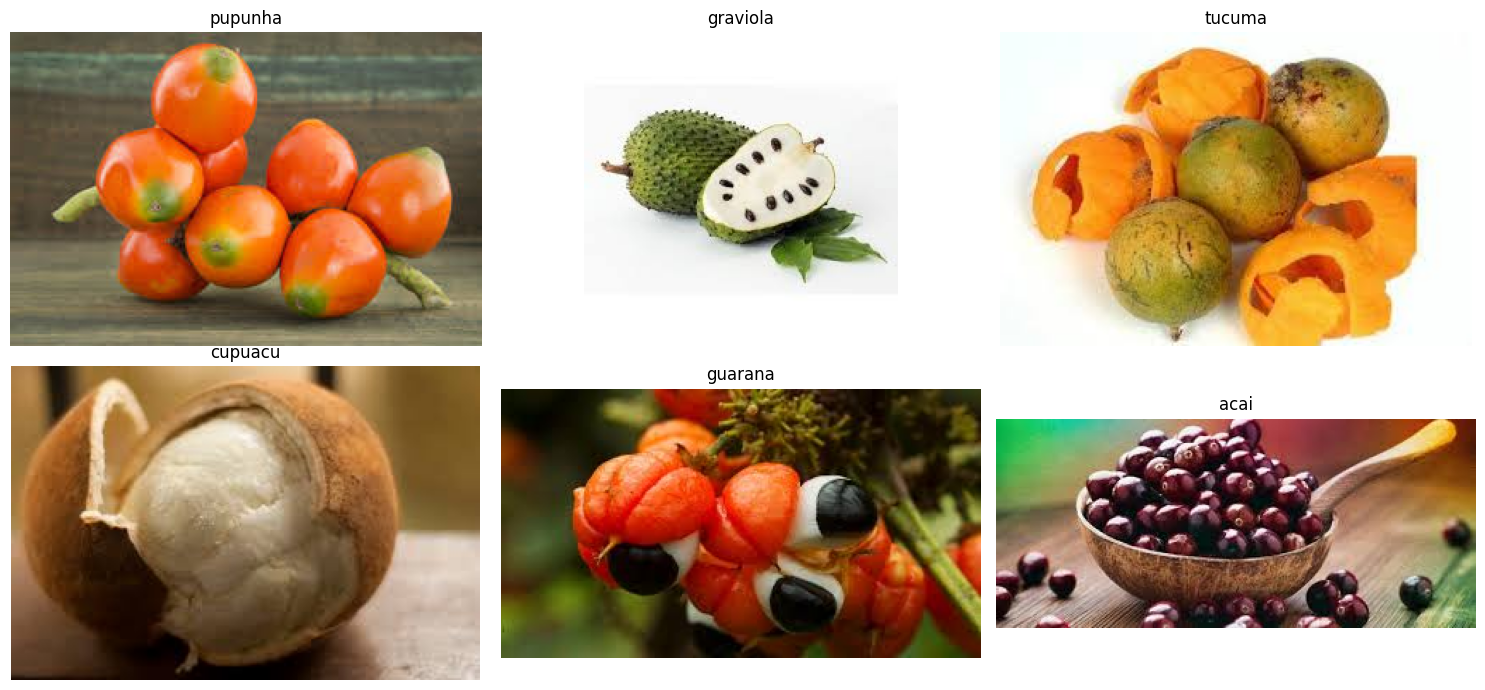

In [128]:
# 1. Loading and Visualizing Images

# Path to the training directory
train_dir = '/kaggle/input/fruits-data/FruitinAmazon/train'

# Get list of class directories
class_dirs = [os.path.join(train_dir, d) for d in os.listdir(train_dir)
              if os.path.isdir(os.path.join(train_dir, d))]

# Select one random image from each class
images_to_display = []
for class_dir in class_dirs:
    images = [os.path.join(class_dir, f) for f in os.listdir(class_dir)
              if f.endswith(('.png', '.jpg', '.jpeg'))]
    if images:
        random_image = random.choice(images)
        images_to_display.append(random_image)

# Display images in a grid format with two rows
num_images = len(images_to_display)
fig, axes = plt.subplots(2, (num_images + 1) // 2, figsize=(15, 7))
axes = axes.flatten()

for i, img_path in enumerate(images_to_display):
    img = mpimg.imread(img_path)
    axes[i].imshow(img)
    axes[i].set_title(os.path.basename(os.path.dirname(img_path)))
    axes[i].axis('off')

for i in range(num_images, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [67]:
# 2. Checking for Corrupted Images

def remove_corrupted_images(directory):
    corrupted_images = []

    # Iterate through each class subdirectory
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            # Iterate through each image in the class directory
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                try:
                    with Image.open(img_path) as img:
                        img.verify()  # Check if the image can be opened
                except (IOError, SyntaxError):
                    # Remove the corrupted image
                    os.remove(img_path)
                    corrupted_images.append(img_path)
                    print(f"Removed corrupted image: {img_path}")

    if not corrupted_images:
        print("No corrupted images found.")

# Run the function
remove_corrupted_images(train_dir)

No corrupted images found.


# Task 2: Loading and Preprocessing Image Data

In [100]:
# Define image parameters
img_height = 224
img_width = 224
batch_size = 32
validation_split = 0.2

# Create training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
    validation_split=validation_split,
    subset='training',
    seed=123
)

# Create validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False,
    validation_split=validation_split,
    subset='validation',
    seed=123
)

# Create normalization layer
normalization_layer = tf.keras.layers.Rescaling(1./255)

# Apply normalization to both datasets
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

Found 90 files belonging to 6 classes.
Using 72 files for training.
Found 90 files belonging to 6 classes.
Using 18 files for validation.


# Task 3: Implementing the CNN Model

In [69]:
from tensorflow.keras.layers import BatchNormalization
layer = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True,
beta_initializer="zeros", gamma_initializer="ones")

In [81]:
from tensorflow.keras.layers import Dropout
layer = Dropout(0.7, noise_shape=None, seed=None)

In [82]:
# Get number of classes
num_classes = len(class_dirs)

# Build the model
model = Sequential([
    # Convolutional Layer 1
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(img_height, img_width, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides=2),
    Dropout(0.25),

    # Convolutional Layer 2
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides=2),
    Dropout(0.25),

    # Fully Connected Network
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)                   │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 128)                 │       4,194,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,214,246 (16.08 MB)

 Trainable params: 4,213,734 (16.07 MB)

 Non-trainable params: 512 (2.00 KB)

# Task 4: Compiling and Training the Model

In [83]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Define callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Save the best model during training
checkpoint = ModelCheckpoint('best_model.keras',
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max',
                             verbose=1)

# Stop training if validation accuracy doesn't improve for 10 epochs
early_stop = EarlyStopping(monitor='val_accuracy',
                           patience=10,
                           restore_best_weights=True)

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    batch_size=16,
    callbacks=[checkpoint, early_stop]
)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2755 - loss: 2.7018 
Epoch 1: val_accuracy improved from -inf to 0.83333, saving model to best_model.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.2726 - loss: 2.7185 - val_accuracy: 0.8333 - val_loss: 0.8938
Epoch 2/10
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.2812 - loss: 1.6699
Epoch 2: val_accuracy did not improve from 0.83333
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2795 - loss: 1.8198 - val_accuracy: 0.8333 - val_loss: 0.9919
Epoch 3/10
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3438 - loss: 2.1092
Epoch 3: val_accuracy did not improve from 0.83333
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4028 - loss: 1.9083 - val_accuracy: 0.8333 - val_loss: 1.2074
Epoch 4/10
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4375 - loss: 1.7498
Epoch 4: val_accuracy did not improve from 0.83333
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4449 - loss: 1.7554 - val_accuracy: 0.

# Task 5: Evaluate the Model

In [84]:
# Evaluate on validation set
val_loss, val_accuracy = model.evaluate(val_ds)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8333 - loss: 0.8938
Validation Loss: 0.8938491344451904
Validation Accuracy: 0.8333333134651184


# Task 6: Save and Load the Model

In [75]:
# Save the model
model.save('fruit_classification_model123.h5')

# Load the model
loaded_model = tf.keras.models.load_model('fruit_classification_model123.h5')

# Task 7: Predictions and Classification Report

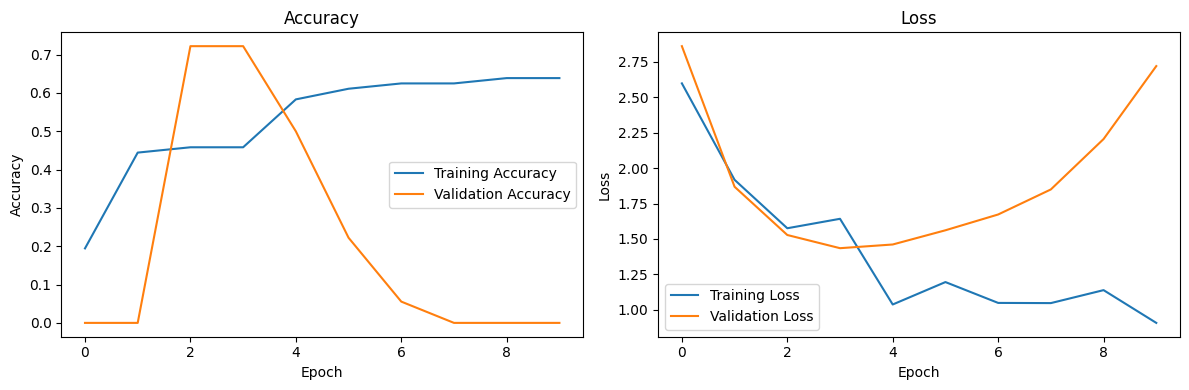

In [76]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

**4 Image classification via fine-tuning with VGG16**

In [86]:
from tensorflow.keras.applications import VGG16
# Load the VGG16 model pre-trained on ImageNet, without the top classification layer
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [88]:
for layer in base_model.layers:
    layer.trainable = False

In [93]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
# Add custom layers on top of the pre-trained model
x = base_model.output
x = GlobalAveragePooling2D()(x) # Reduces dimensions (height, width) to a single vector per image
x = Dense(1024, activation="relu")(x) # Fully connected layer with 1024 neurons
x = Dense(6, activation="softmax")(x) # Output layer for 10 classes (with softmax for multi-classclassification)

In [98]:
from tensorflow.keras.models import Model
# Create the final model
model1 = Model(inputs=base_model.input, outputs=x)

In [102]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
# Compile the model
model1.compile(optimizer=Adam(), loss="SparseCategoricalCrossentropy", metrics=["accuracy"])
model1.fit( train_ds,
    validation_data=val_ds,
    epochs=10,
    batch_size=16,
    callbacks=[checkpoint, early_stop])


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2350 - loss: 1.8535  
Epoch 1: val_accuracy did not improve from 0.83333
3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - accuracy: 0.2352 - loss: 1.8534 - val_accuracy: 0.5000 - val_loss: 1.4775
Epoch 2/10
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.4531 - loss: 1.6207 
Epoch 2: val_accuracy did not improve from 0.83333
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.4696 - loss: 1.5864 - val_accuracy: 0.6667 - val_loss: 1.3478
Epoch 3/10
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7422 - loss: 1.2905 
Epoch 3: val_accuracy did not improve from 0.83333
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.7322 - loss: 1.2853 - val_accuracy: 0.6111 - val_loss: 1.2031
Epoch 4/10
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7656 - loss: 1.1680 
Epoch 4: val_accuracy did not improve from 0.83333
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.7786 - loss: 1.1441 - val_accuracy: 0.5556 - val_loss: 1.2611
Epoch 

**Task 2**

In [118]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load MobileNetV2 without the top layer (include_top=False)
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights="imagenet")

# Freeze all layers of the base model
base_model.trainable = False

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling layer to reduce dimensionality
x = Flatten()(x)  # Flatten the output after pooling
x = Dense(128, activation="relu")(x)
x = Dense(64, activation="relu")(x)
output_layer = Dense(6, activation="softmax")(x)  # 6 classes for fruit classification

# Create the final model
model2 = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
model2.compile(optimizer=Adam(learning_rate=0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Show model summary
model2.summary()


Model: "functional_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_15[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,430,598 (9.27 MB)

 Trainable params: 172,614 (674.27 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [121]:


epochs = 15  # Adjust as needed

history = model2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)


Epoch 1/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 1.0000 - loss: 0.0093 - val_accuracy: 0.9444 - val_loss: 0.3138
Epoch 2/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 1.0000 - loss: 0.0066 - val_accuracy: 0.9444 - val_loss: 0.3196
Epoch 3/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 1.0000 - loss: 0.0041 - val_accuracy: 0.9444 - val_loss: 0.3252
Epoch 4/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 0.9444 - val_loss: 0.3285
Epoch 5/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 0.9444 - val_loss: 0.3309
Epoch 6/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.9444 - val_loss: 0.3300
Epoch 7/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.9444 - val_loss: 0.3254
Epoch 8/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.9444 - val_loss: 0.3143


In [142]:
import numpy as np
from sklearn.metrics import classification_report

# Get true labels and predictions
true_labels = np.concatenate([y for x, y in val_ds], axis=0)
pred_probs = model2.predict(val_ds)
pred_labels = np.argmax(pred_probs, axis=1)

# Generate classification report
class_names = train_ds.class_names  # Get class names from dataset
report = classification_report(true_labels, pred_labels, target_names=class_names)
print(report)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


AttributeError: '_MapDataset' object has no attribute 'class_names'